# Kriging vs. Simulation, 1D

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

This is a tutorial for / demonstration of **Spatial Estimation with Kriging vs. Simulation with Sequential Gaussian Simulation (SGSIM)** with a 1D example.

* this is the fluctuations in the reproduction of input statistics over multiple simulation realizations.

**YouTube Lecture**: check out my lecture on [Stochastic Simulation](https://youtu.be/3cLqK3lR56Y?si=3WhHX5QOZrrtlgAI). For your convenience here's a summary of slalient points.

#### Estimation vs. Simulation

Let's start by comparing spatial estimation and simulation.

Estimation: 

* honors local data 
* locally accurate, primary goal of estimation is 1 estimate! 
* too smooth, appropriate for visualizing trends 
* too smooth, inappropriate for flow simulation 
* one model, no assessment of global uncertainty 

Simulation: 

* honors local data 
* sacrifices local accuracy, reproduces histogram 
* honors spatial variability, appropriate for flow simulation 
* alternative realizations, change random number seed 
* many models (realizations), assessment of global uncertainty

#### Spatial Estimation

Consider the case of making an estimate at some unsampled location, $𝑧(\bf{u}_0)$, where $z$ is the property of interest (e.g. porosity etc.) and $𝐮_0$ is a location vector describing the unsampled location.

How would you do this given data, $𝑧(\bf{𝐮}_1)$, $𝑧(\bf{𝐮}_2)$, and $𝑧(\bf{𝐮}_3)$?

It would be natural to use a set of linear weights to formulate the estimator given the available data.

$$
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha})
$$

We could add an unbiasedness constraint to impose the sum of the weights equal to one.  What we will do is assign the remainder of the weight (one minus the sum of weights) to the global average; therefore, if we have no informative data we will estimate with the global average of the property of interest.

$$
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha}) + \left(1-\sum^{n}_{\alpha = 1} \lambda_{\alpha} \right) \overline{z}
$$

We will make a stationarity assumption, so let's assume that we are working with residuals, $y$. 

$$
y^{*}(\bf{u}) = z^{*}(\bf{u}) - \overline{z}(\bf{u})
$$

If we substitute this form into our estimator the estimator simplifies, since the mean of the residual is zero.

$$
y^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} y(\bf{u}_{\alpha})
$$

while satisfying the unbaisedness constraint.  

#### Kriging

Now the next question is what weights should we use?  

We could use equal weighting, $\lambda = \frac{1}{n}$, and the estimator would be the average of the local data applied for the spatial estimate. This would not be very informative.

We could assign weights considering the spatial context of the data and the estimate:

* **spatial continuity** as quantified by the variogram (and covariance function)
* **redundancy** the degree of spatial continuity between all of the available data with themselves 
* **closeness** the degree of spatial continuity between the avaiable data and the estimation location

The kriging approach accomplishes this, calculating the best linear unbiased weights for the local data to estimate at the unknown location.  The derivation of the kriging system and the resulting linear set of equations is available in the lecture notes.  Furthermore kriging provides a measure of the accuracy of the estimate!  This is the kriging estimation variance (sometimes just called the kriging variance).

$$
\sigma^{2}_{E}(\bf{u}) = C(0) - \sum^{n}_{\alpha = 1} \lambda_{\alpha} C(\bf{u}_0 - \bf{u}_{\alpha})
$$

What is 'best' about this estimate? Kriging estimates are best in that they minimize the above estimation variance. 

##### Properties of Kriging

Here are some important properties of kriging:

* **Exact interpolator** - kriging estimates with the data values at the data locations
* **Kriging variance** can be calculated before getting the sample information, as the kriging estimation variance is not dependent on the values of the data nor the kriging estimate, i.e. the kriging estimator is homoscedastic. 
* **Spatial context** - kriging takes into account, furthermore to the statements on spatial continuity, closeness and redundancy we can state that kriging accounts for the configuration of the data and structural continuity of the variable being estimated.
* **Scale** - kriging may be generalized to account for the support volume of the data and estimate. We will cover this later.
* **Multivariate** - kriging may be generalized to account for multiple secondary data in the spatial estimate with the cokriging system. We will cover this later.
* **Smoothing effect** of kriging can be forecast. We will use this to build stochastic simulations later.

I have more on this topic at [Krigign YouTube Lecture](https://youtu.be/CVkmuwF8cJ8).

#### Sequential Gaussian Simulation

With sequential Gaussian simulation we build on kriging by:

* adding a random residual with the missing variance

* sequentially adding the simulated values as data to correct the covariance between the simulated values

The resulting model corrects the issues of kriging, as we now:

* reproduce the global feature PDF / CDF

* reproduce the global variogram

* while providing a model of uncertainty through multiple realizations

In this workflow we run kriging estimates and multiple simulation realizations, and compare the statistics.

#### Load the required libraries

The following code loads the required libraries. 

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.71


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # supress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrys for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # custom subplots
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
from IPython.utils import io                                  # mute output from simulation

#### Simulation Parameters, Data with Reference Distribution (values outside AOI)

* we need a full distribution of values outside the AOI to support the distribution transformation of sequential Gaussian simulation

* while the data will inform the distribution transformation, they are outside the range of spatial continuity and will not locally condition the model

In [3]:
nx = 100; ny = 1; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1 # grid specification
ndmin = 0; ndmax = 20; radius = 2000; skmean = 0; tmin = -99999; tmax = 99999; nreal = 10 # simulation parameters

df = pd.DataFrame(np.vstack([np.full(1000,-9999),np.random.normal(size=1000), # reference distribution outside VOI
                np.random.normal(loc=1000,scale=200,size=1000)]).T, columns= ['X','Y','Lithium'])

df.loc[0,'X'] = 105; df.loc[0,'Y'] = 5.0; df.loc[0,'Lithium'] = 800 # add 3 data in VOI for visualization of conditioning
df.loc[1,'X'] = 505; df.loc[1,'Y'] = 5.0; df.loc[1,'Lithium'] = 1000
df.loc[2,'X'] = 905; df.loc[2,'Y'] = 5.0; df.loc[2,'Lithium'] = 950

df.head()

,X,Y,Lithium
0,105.0,5.000000,800.000000
1,505.0,5.000000,1000.000000
2,905.0,5.000000,950.000000
3,-9999.0,0.399541,1149.752294
4,-9999.0,0.498007,1023.937388


#### Make Truth Model

For visualization, simulate a consistent truth model.

* we use the same reference distribution and variogram model for truth and realizations, assuming perfect / no error inference

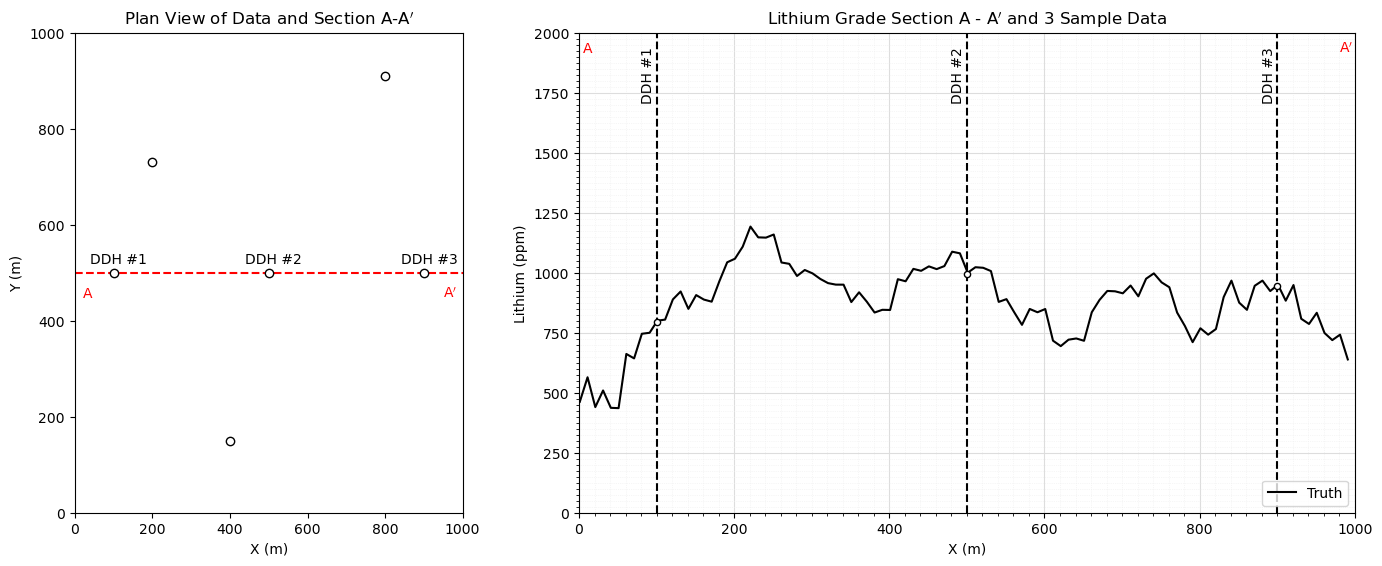

In [4]:
nreal = 50; vrange = 300                                      # number of realizations and variogram range
vario_truth = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=vrange,hmin1=5) # assumed variogram model

fig = plt.figure()
grid_spec = gridspec.GridSpec(ncols = 2,nrows=1,width_ratios=[1, 2])

ax0 = fig.add_subplot(grid_spec[0])                           # visualize the truth and realizations

ax0.scatter([100,500,900,400,200,800],[500,500,500,150,730,910],color='white',edgecolor='black',zorder=10) # data for viz
plt.plot([0,1000],[500,500],ls='--',color='red',zorder=1)
plt.annotate(r'DDH #1',(40,520)); plt.annotate(r'DDH #2',(440,520)) ## 3 conditioning data on the section
plt.annotate(r'DDH #3',(840,520)) 
plt.annotate(r'A',(20,450),color='red'); plt.annotate(r'A$^\prime$',(950,450),color='red')  

plt.xlim([0,1000]); plt.ylim([0,1000]); plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Plan View of Data and Section A-A$^\prime$')

ax1 = fig.add_subplot(grid_spec[1])                           # cross section
with io.capture_output() as captured:                         # mute simulation output
    truth = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
        twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73067,
        ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,
        ktype=0,colocorr=0.0,sec_map=0,vario=vario_truth)[0][0]

ax1.plot(np.arange(1,(nx*xsiz),xsiz),truth,color='black',label='Truth',zorder=1)
        
plt.annotate(r'DDH #1',(80,1720),rotation = 90); plt.annotate(r'DDH #2',(480,1720),rotation = 90) 
plt.annotate(r'DDH #3',(880,1720),rotation = 90) 

plt.annotate(r'A',(5,1920),color='red'); plt.annotate(r'A$^\prime$',(980,1920),color='red') 

plt.scatter(500,995,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(100,795,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(900,945,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([100,100],[0,2000],color='black',ls='--'); plt.plot([900,900],[0,2000],color='black',ls='--')
plt.plot([500,500],[0,2000],color='black',ls='--')
  
plt.legend(loc='lower right')    

plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Grade Section A - A$^\prime$ and 3 Sample Data')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

#### Estimation Model

We only estimate in 1D along the section and only use the 3 indicated data

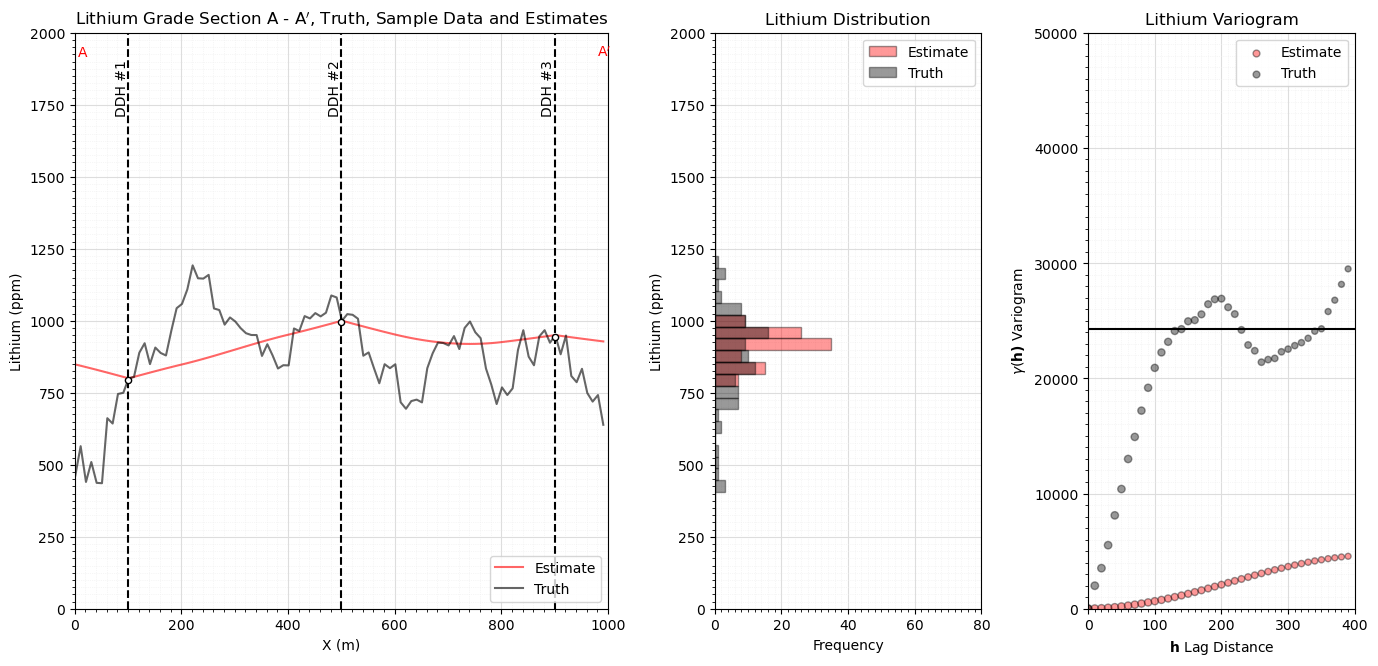

In [5]:
%%capture --no-display     

fig = plt.figure()
grid_spec = gridspec.GridSpec(ncols = 3,nrows=1,width_ratios=[2, 1, 1])

ax0 = fig.add_subplot(grid_spec[0])

estimate, est_var = geostats.kb2d(df,'X','Y','Lithium',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis=1,nydis=1,
         ndmin=0,ndmax=10,radius=500,ktype=0,skmean=900,vario=vario_truth)
    
ax0.plot(np.arange(1,(nx*xsiz),xsiz),estimate[0],color='red',alpha=0.6,label='Estimate',zorder=1)
ax0.plot(np.arange(1,(nx*xsiz),xsiz),truth,color='black',alpha=0.6,label='Truth',zorder=1)
    
plt.annotate(r'DDH #1',(75,1720),rotation = 90); plt.annotate(r'DDH #2',(475,1720),rotation = 90) 
plt.annotate(r'DDH #3',(875,1720),rotation = 90) 

plt.annotate(r'A',(5,1920),color='red'); plt.annotate(r'A$^\prime$',(980,1920),color='red') 

plt.scatter(500,995,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(100,795,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(900,945,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([100,100],[0,2000],color='black',ls='--'); plt.plot([900,900],[0,2000],color='black',ls='--')
plt.plot([500,500],[0,2000],color='black',ls='--')
    
plt.legend(loc='lower right')    
    
plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Grade Section A - A$^\prime$, Truth, Sample Data and Estimates')

ax1 = fig.add_subplot(grid_spec[1])                           # visualize the CDFs

ax1.hist(estimate[0],bins=np.linspace(200,1800,40),color='red',alpha=0.4,edgecolor='black',label='Estimate',orientation='horizontal')
ax1.hist(truth,bins=np.linspace(200,1800,40),color='black',alpha=0.4,edgecolor='black',label='Truth',orientation='horizontal')
plt.ylabel('Lithium (ppm)'); plt.xlabel('Frequency'); plt.title('Lithium Distribution')
plt.ylim([0,2000]); plt.xlim([0,80]); plt.grid()

gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)

plt.legend(loc='upper right')    

ax2 = fig.add_subplot(grid_spec[2])                           # visualize experimental variograms

truth_series = pd.Series(truth); estimate_series = pd.Series(estimate[0])

gamma_estimate = []; gamma_truth = []; num_pairs_all = []
for ilag in range(0,40):
    num_pairs_all.append(float(len((truth_series - truth_series.shift(ilag)).dropna())))
    gamma_truth.append(np.average(np.square((truth_series - truth_series.shift(ilag)).dropna()))*0.5)  
    gamma_estimate.append(np.average(np.square((estimate_series - estimate_series.shift(ilag)).dropna()))*0.5)  

lithium_var = np.var(truth)
scatter = ax2.scatter(np.arange(0,40)*xsiz,gamma_estimate,s=np.array(num_pairs_all)*0.3,color='red',alpha=0.4,edgecolor='black',label='Estimate')
plt.scatter(np.arange(0,40)*xsiz,gamma_truth,s=np.array(num_pairs_all)*0.3,color='black',alpha=0.4,edgecolor='black',label='Truth')
plt.plot([0,400],[lithium_var,lithium_var],color='black')
plt.xlim([0,400]); plt.ylim([0,50000]); plt.title('Lithium Variogram')
plt.xlabel(r'$\bf{h}$ Lag Distance'); plt.ylabel(r'$\gamma(\bf{h})$ Variogram')

gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)

plt.legend(loc='upper right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.3, hspace=0.2); plt.show()

#### Simulation Models

We only simulate in 1D along the section and only use the 3 data on the section for simplicity and ease of visualization.

* here we look at the realization, histogram and variogram for each realization

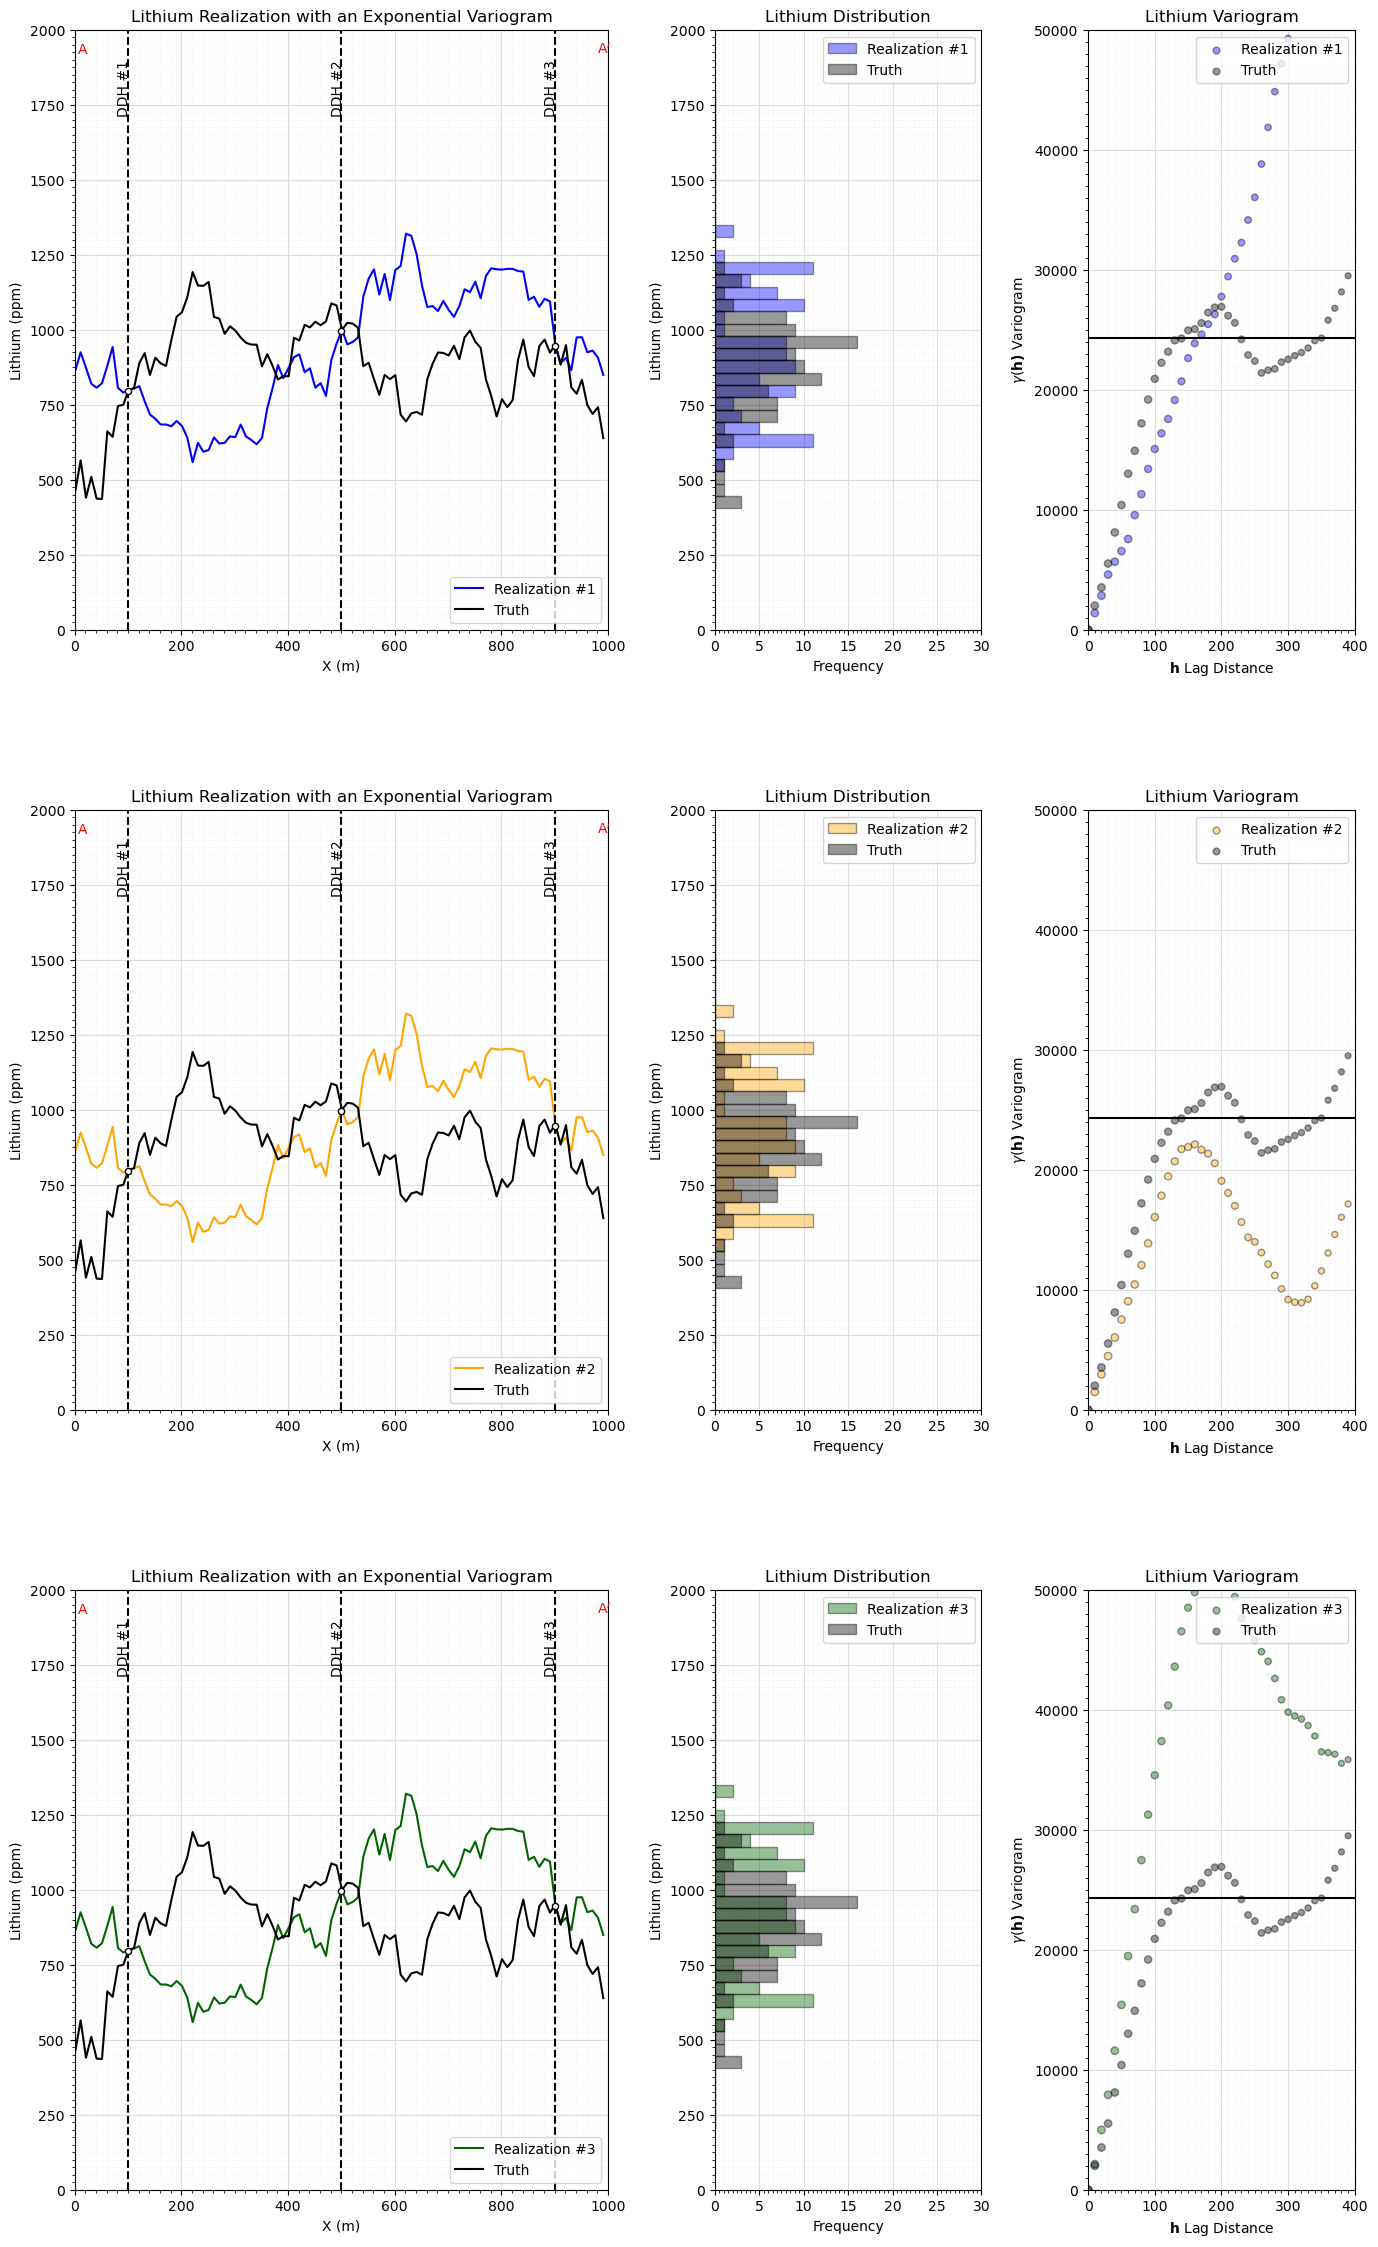

In [6]:
%%capture --no-display     

nreal = 3                                                     # number of realizations and variogram range

color = ['blue','orange','darkgreen']

fig = plt.figure()
grid_spec = gridspec.GridSpec(ncols = 3,nrows=3,width_ratios=[2, 1, 1])

lithium_var = np.var(truth)

with io.capture_output() as captured:
    sim = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
        twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=nreal,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074,
        ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,
        ktype=0,colocorr=0.0,sec_map=0,vario=vario_truth).reshape(nreal,nx);
    
for i in range(0, nreal):
    j = i*3
    ax = fig.add_subplot(grid_spec[j])
    ax.plot(np.arange(1,(nx*xsiz),xsiz),sim[0],color=color[i],label='Realization #' + str(i+1),zorder=1)
    ax.plot(np.arange(1,(nx*xsiz),xsiz),truth,color='black',label='Truth',zorder=1)
    
    plt.annotate(r'DDH #1',(80,1720),rotation = 90); plt.annotate(r'DDH #2',(480,1720),rotation = 90) 
    plt.annotate(r'DDH #3',(880,1720),rotation = 90) 
    
    plt.annotate(r'A',(5,1920),color='red'); plt.annotate(r'A$^\prime$',(980,1920),color='red') 
    
    plt.scatter(500,995,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(100,795,s=20,color='white',edgecolor='black',zorder=10)
    plt.scatter(900,945,s=20,color='white',edgecolor='black',zorder=10)
    
    plt.plot([100,100],[0,2000],color='black',ls='--'); plt.plot([900,900],[0,2000],color='black',ls='--')
    plt.plot([500,500],[0,2000],color='black',ls='--')
     
    plt.legend(loc='lower right') 
        
    plt.ylim([0,2000]); plt.xlim([0,1000]) 
    gca = plt.gca()
    gca.xaxis.set_minor_locator(AutoMinorLocator(10))
    gca.yaxis.set_minor_locator(AutoMinorLocator(10))
    gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realization with an Exponential Variogram')

    h = i*3+1
    ax2 = fig.add_subplot(grid_spec[h])  

    ax2.hist(sim[0],bins=np.linspace(200,1800,40),color=color[i],alpha=0.4,edgecolor='black',label='Realization #' + str(i+1),orientation='horizontal')
    ax2.hist(truth,bins=np.linspace(200,1800,40),color='black',alpha=0.4,edgecolor='black',label='Truth',orientation='horizontal')
    plt.ylabel('Lithium (ppm)'); plt.xlabel('Frequency'); plt.title('Lithium Distribution')
    plt.ylim([0,2000]); plt.xlim([0,30]); plt.grid()
    
    gca = plt.gca()
    gca.xaxis.set_minor_locator(AutoMinorLocator(10))
    gca.yaxis.set_minor_locator(AutoMinorLocator(10))
    gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
    
    plt.legend(loc='upper right')   
   
    g = i*3+2
    ax2 = fig.add_subplot(grid_spec[g])

    truth_series = pd.Series(truth); sim_series = pd.Series(sim[i])
    
    gamma_sim = []; gamma_truth = []; num_pairs_all = []
    for ilag in range(0,40):
        num_pairs_all.append(float(len((truth_series - truth_series.shift(ilag)).dropna())))
        gamma_truth.append(np.average(np.square((truth_series - truth_series.shift(ilag)).dropna()))*0.5)  
        gamma_sim.append(np.average(np.square((sim_series - sim_series.shift(ilag)).dropna()))*0.5)  
    
    scatter = ax2.scatter(np.arange(0,40)*xsiz,gamma_sim,s=np.array(num_pairs_all)*0.3,color=color[i],alpha=0.4,edgecolor='black',label='Realization #' + str(i+1))
    plt.scatter(np.arange(0,40)*xsiz,gamma_truth,s=np.array(num_pairs_all)*0.3,color='black',alpha=0.4,edgecolor='black',label='Truth')
    plt.plot([0,400],[lithium_var,lithium_var],color='black')
    plt.xlim([0,400]); plt.ylim([0,50000]); plt.title('Lithium Variogram')
    plt.xlabel(r'$\bf{h}$ Lag Distance'); plt.ylabel(r'$\gamma(\bf{h})$ Variogram')
    
    gca = plt.gca()
    gca.xaxis.set_minor_locator(AutoMinorLocator(10))
    gca.yaxis.set_minor_locator(AutoMinorLocator(10))
    gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
    
    plt.legend(loc='upper right')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.5, wspace=0.3, hspace=0.3); plt.show()

#### Many Realizations

Now let's make a lot of simulated realizations and plot them with the one estimation model.

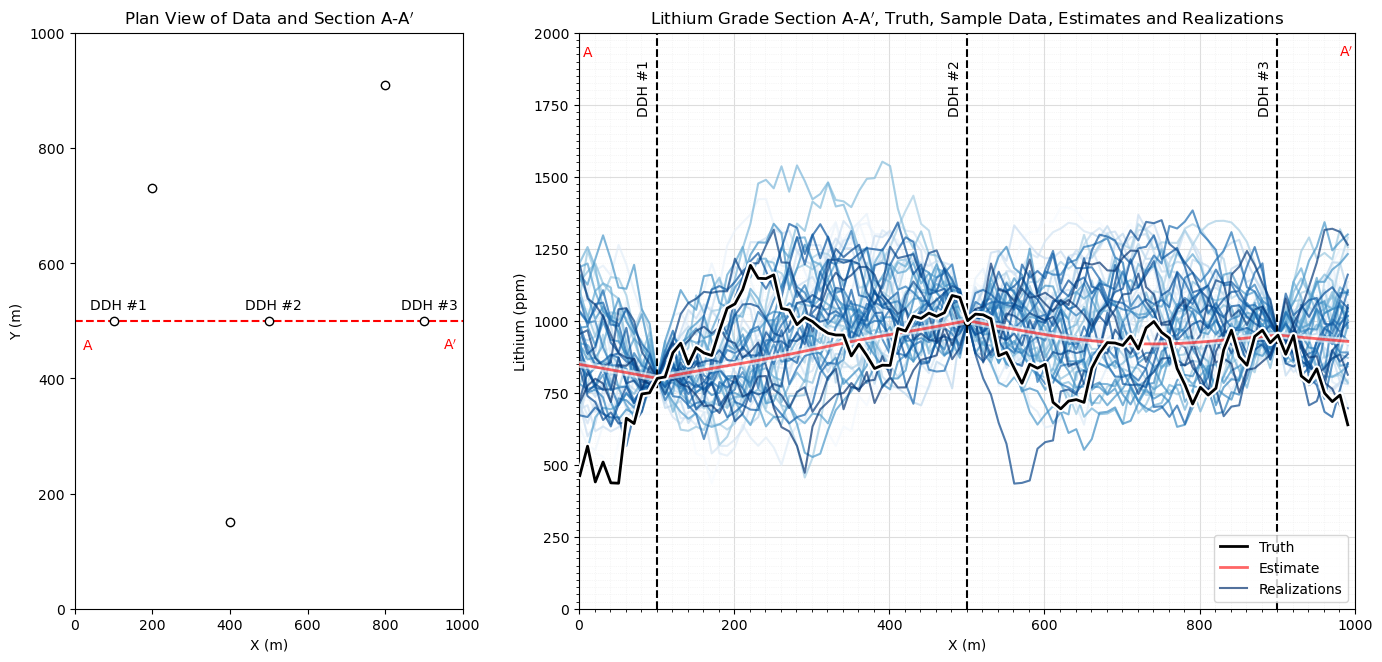

In [7]:
%%capture --no-display     

nreal = 50

fig = plt.figure()
grid_spec = gridspec.GridSpec(ncols = 2,nrows=1,width_ratios=[1, 2])

ax0 = fig.add_subplot(grid_spec[0])

ax0.scatter([100,500,900,400,200,800],[500,500,500,150,730,910],color='white',edgecolor='black',zorder=10)
plt.plot([0,1000],[500,500],ls='--',color='red',zorder=1)
plt.annotate(r'DDH #1',(40,520)); plt.annotate(r'DDH #2',(440,520)) 
plt.annotate(r'DDH #3',(840,520)) 
plt.annotate(r'A',(20,450),color='red'); plt.annotate(r'A$^\prime$',(950,450),color='red')  

plt.xlim([0,1000]); plt.ylim([0,1000]); plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Plan View of Data and Section A-A$^\prime$')

ax1 = fig.add_subplot(grid_spec[1])

with io.capture_output() as captured:
    sim_gaussian = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
        twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=nreal,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074+i,
        ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,
        ktype=0,colocorr=0.0,sec_map=0,vario=vario_truth).reshape((nreal,nx));
        
ax1.plot(np.arange(1,(nx*xsiz),xsiz),truth,color='black',label='Truth',lw=2,zorder=20)
ax1.plot(np.arange(1,(nx*xsiz),xsiz),truth,color='white',lw=5,zorder=15)

ax1.plot(np.arange(1,(nx*xsiz),xsiz),estimate[0],color='red',alpha=0.6,lw=2,label='Estimate',zorder=10)
ax1.plot(np.arange(1,(nx*xsiz),xsiz),estimate[0],color='white',alpha=0.6,lw=5,zorder=5)

for i in range(0, nreal):
    if i == nreal - 1:
        ax1.plot(np.arange(1,(nx*xsiz),xsiz),sim_gaussian[i],color=plt.cm.Blues(i/nreal),alpha=0.7,zorder=1,label='Realizations')
    else:
        ax1.plot(np.arange(1,(nx*xsiz),xsiz),sim_gaussian[i],color=plt.cm.Blues(i/nreal),alpha=0.7,zorder=1)  

plt.annotate(r'DDH #1',(75,1720),rotation = 90); plt.annotate(r'DDH #2',(475,1720),rotation = 90) 
plt.annotate(r'DDH #3',(875,1720),rotation = 90) 

plt.annotate(r'A',(5,1920),color='red'); plt.annotate(r'A$^\prime$',(980,1920),color='red') 

plt.scatter(500,995,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(100,795,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(900,945,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([100,100],[0,2000],color='black',ls='--'); plt.plot([900,900],[0,2000],color='black',ls='--')
plt.plot([500,500],[0,2000],color='black',ls='--')
    
plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Grade Section A-A$^\prime$, Truth, Sample Data, Estimates and Realizations')

plt.legend(loc='lower right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration and comparison of spatial estimation vs. spatial simulation with kriging and sequential Gaussian simulation from GeostatsPy. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
  